In [3]:
import os
import sys

# Add project root to path to allow importing from model
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from model.utils.validation_utils import test_prop_partial_discretization_matches_ode

# To make plots appear in the notebook
%matplotlib inline

# Model Validations

The purpose of this notebook is to validate the outputs generated by our discretized, modified Lotka-Volterra (LV) agent-based model (ABM) as being consistent with expectations given the equations of the system and the goals of our implementation.

## Introduction To The System

The standard LV system is described as:

$$
\begin{align}
\frac{ds}{dt} &= \alpha x - \beta xy \\
\frac{dw}{dt} &= -\gamma y + \delta xy
\end{align}
$$

where (adapted from [Wikipedia's Lotka-Volterra equations page](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)):[^1]

- The variable $x$ is the population of prey (for example, the number of rabbits per square kilometre)
- The variable $y$ is the population of some predator (for example, the number of foxes per square kilometre)  
- $\frac{dy}{dt}$ and $\frac{dx}{dt}$ represent the instantaneous growth rates of the two populations
- $t$ represents time
- The prey's parameters, $\alpha$ and $\beta$, describe, respectively, the maximum prey per capita growth rate, and the effect of the presence of predators on the prey death rate
- The predator's parameters, $\gamma$ and $\delta$, respectively describe the predator's per capita death rate, and the effect of the presence of prey on the predator's growth rate
- All parameters are positive and real

### Introduction

Our implementation of Lotka-Volterra employs wolves (predators) and sheep (prey) as model organisms. Additionally, our system employs an additional parameter in complex with the intrinsic $\beta$ parameter of "base" LV called $\theta$. The complex is added to both equations of the system in order to add and balance a "predation intensity" term which is somewhat like the one proposed by Holling (1973). However, for the purposes of our validation, the $\theta\ parameter will always be set to one, thus "washing out" of our model. So:

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \theta\beta sw \\
\frac{dw}{dt} &= -\gamma w + \theta\beta\delta sw
\end{align}
$$

where $w$ is number of wolves and $s$ number of sheep. Elsewhere in this notebook we will omit the $\theta$ variable.

In our "partially discretized" model implementation of the LV system, the continuous curve of the predator population, wolves, is replaced by the use of a model implementation in which wolf "agents" are individualized and have discrete, integer population counts at every step. The discrete population notably cannot rebound from a sub-1 value.  The prey population, the sheep, are left to operate as a single population group, with non-discrete (implemented as a floating point number, so our discretion is limited!) populations that can exist at sub-1 counts.

The implementation of discretized systems is widely discussed and debated in simulation and agent-based modeling literature. [CITATIONS]

Our approach is based on the forward Euler method for solving ordinary differential equations (ODE). The details of our approach are described in the accompanying notebook, `introducing_do_android_wolves.ipynb`. To simplify, each step [DETAILS] 

*** [Solvers details] ***

## Hypotheses

Hypothesis One

We can first hypothesize that an idiomatic Python implementation of a forward Euler solution to (modified) LV will depart from the solution generated by a Solver with an error-per step ratio corresponding to known calculations [known calculations]

Hypothesis Two

Next, we can hypothesize that our partially discretized ABM implementation will depart from the solution generated by a Solver with a similar error-per step ratio.




## Test One: Forward-Euler versus solver


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

# The reference function: modified LV.
def reference_function(x, t, alpha, beta, gamma, delta):  # noqa
    # Note the omission of theta
    s, w = x
    ds_dt = alpha * s - beta * s * w
    dw_dt = -gamma * w + beta * delta * s * w
    return [ds_dt, dw_dt]

def partial_reference_function(x, t, alpha, beta, gamma, delta):  # noqa
    # Note the omission of theta
    s, w = x
    ds_dt = alpha * s - beta * s * w
    dw_dt = -gamma * w + beta * delta * s * w
    return [ds_dt, dw_dt]


In [ ]:


def ivp_solver(x, t, alpha, beta, gamma, delta):  # noqa
    # Using solve_ivp from scipy.integrate,
    # documented at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
    # Define parameters
    s  # Initial conditions
    x0 = [model_params["s_start"], model_params["w_start"]]

    # Solve the ODE
    solution = solve_ivp(
        dx_dt_ivp,
        [0, t_end],
        x0,
        t_eval=t_eval,
        events=events,
        method="DOP853",
        rtol=1e-8,
        atol=1e-10,
    )


# Define parameters
alpha = 1.0
beta = 0.2
gamma = 1.5
delta = 0.75

5001


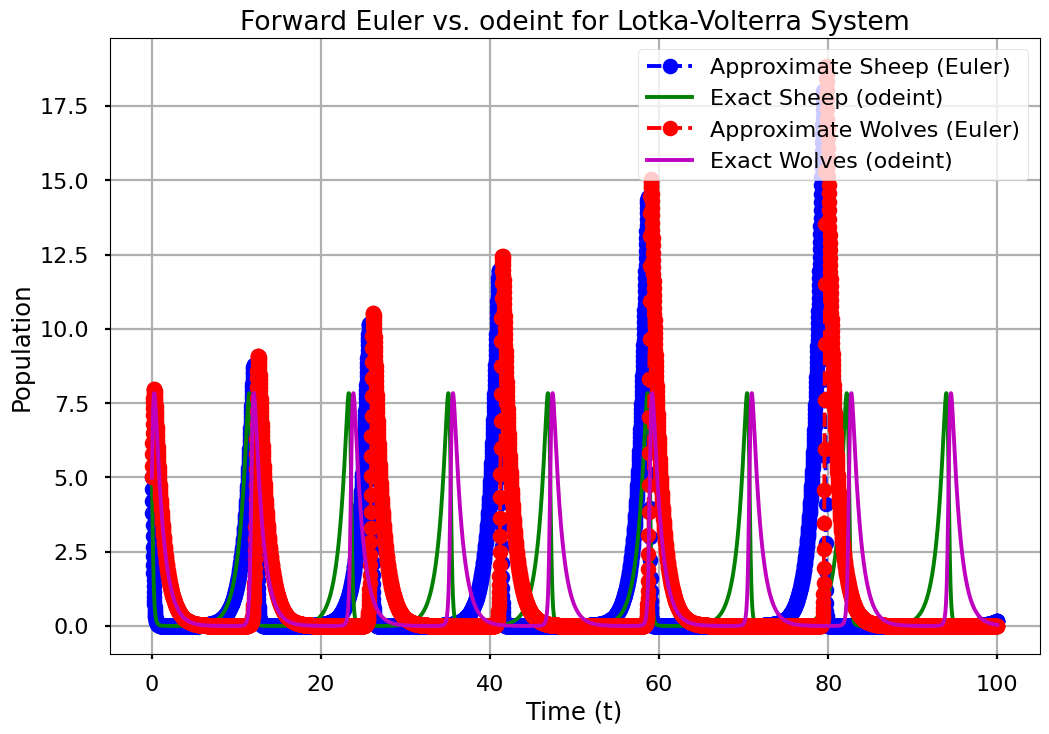

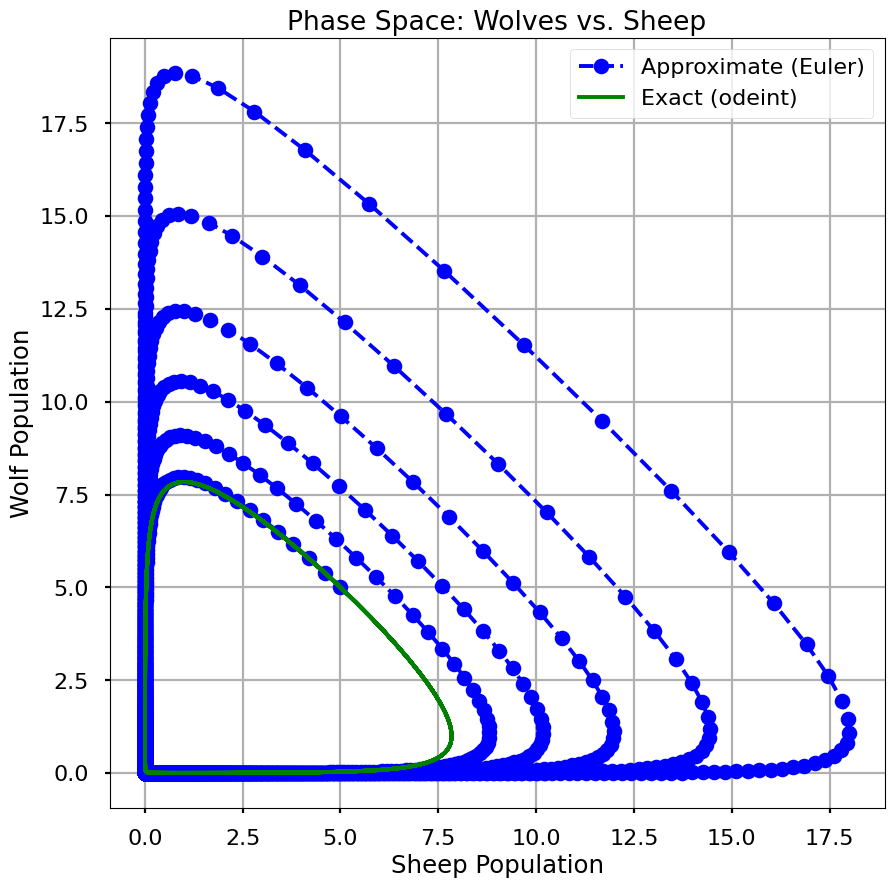

In [29]:


def forward_euler_solver(initial_conditions, dt, max_step, a, b, c, d):
    # Deal with time and initiailize the solution array
    t = np.arange(0, max_step + dt, dt)  # all the steps to max_step counting from 0
    print(len(t))
    # The referenced code works on one variable/one equation, here we simply need two state arrays.
    s = np.zeros(len(t))
    w = np.zeros(len(t))
    s[0] = initial_conditions[0]
    w[0] = initial_conditions[1]

    # since we have two functions in our system, we need to split them into their own lambda functions.
    f_s = lambda t, s, w: a * s - b * s * w             # noqa
    f_w = lambda t, s, w: -c * w + b * d * s * w        # noqa
    # note: autonomous functions, t is not actually used to process.

    # Here is the code from the referenced notebook. We need to do this twice, basically
    # for i in range(0, len(t) - 1):
    # s[i + 1] = s[i] + h*f(t[i], s[i])
    # note that our dt is h!

    for i in range(0, len(t) - 1):
        s[i + 1] = s[i] + dt*f_s(t[i], s[i], w[i])
        w[i + 1] = w[i] + dt*f_w(t[i], s[i], w[i])

    return t, s, w

# Model parameters for oscillatory behavior
alpha = 1.0
beta = 1.0
gamma = 1.0
delta = 1.0
s_start = 5
w_start = 5
dt = 0.02
max_step = 100

# Time array for the solvers
t = np.arange(0, max_step + dt, dt)

# 1. Get approximate solution from our Forward Euler solver
t_euler, s_euler, w_euler = forward_euler_solver([s_start, w_start], dt, max_step, alpha, beta, gamma, delta)

# 2. Get "exact" solution from SciPy's odeint
solution = integrate.odeint(reference_function, [s_start, w_start], t, args=(alpha, beta, gamma, delta))
s_exact = solution[:,0]
w_exact = solution[:,1]


# 3. Plot the time-series results
plt.style.use('seaborn-v0_8-poster')
plt.figure(figsize = (12, 8))

plt.plot(t_euler, s_euler, 'bo--', label='Approximate Sheep (Euler)')
plt.plot(t, s_exact, 'g-', label='Exact Sheep (odeint)')
plt.plot(t_euler, w_euler, 'ro--', label='Approximate Wolves (Euler)')
plt.plot(t, w_exact, 'm-', label='Exact Wolves (odeint)')

plt.title('Forward Euler vs. odeint for Lotka-Volterra System')
plt.xlabel('Time (t)')
plt.ylabel('Population')
plt.grid()
plt.legend(loc='upper right')
plt.show()

# 4. Create the Phase Space Plot
plt.figure(figsize=(10, 10))
plt.plot(s_euler, w_euler, 'bo--', label='Approximate (Euler)')
plt.plot(s_exact, w_exact, 'g-', label='Exact (odeint)')
plt.title('Phase Space: Wolves vs. Sheep')
plt.xlabel('Sheep Population')
plt.ylabel('Wolf Population')
plt.grid()
plt.legend(loc='upper right')
plt.show()


## Data assembly

We will be performing several runs through the LV system in this notebook, and some parameters will vary from run to run. Generally speaking for the project we are not so interested in the outcome permutations generated by the traditional LV variables, as the effects of different settings of these parameters is well-settled science. However, we might be interested to confirm whether or not our system diverges from the main system, so we will investigate this in a bit.

To get started, we will use the parameters we employ throughout the study:
```
        "alpha": 1,
        "beta": 0.1,
        "gamma": 1.5,
        "delta": 0.75,
```

This means that our system equations will evaluate as:

```
        ds_dt = 1 * s - 0.1 * s * w
        dw_dt = -1.5 * w + 0.75 * s * w
```

... where `w` and `s` are our sheep and wolves counts. Let's take a look at the solver working with these equations, 


and we will watch the ODE solver compute an output using these numbers.

## A note on time and solvers

One theoretical difference between our discretized model and the continous functions they are intended to instantiate is the modeling application of finite time. Effectively, in order for our model to be a model, our model agents need discrete time points at which they can observe and interact with the environment. Meanwhile, since we are attempting to orchestrate domain processes that operate according to the continous system, our discrete time points also need enough organization so that we can reassemble their history in a way that they can be compared against a similar amount of continuous time. We accomplish this, in the case of this and many other models, using "steps," which are points in time spaced equally using a variable we call `dt`. This variable name is of course not an accident; our `dt` is designed to match up with the same "delta time (dt)" variable governing the continuous system.

As a result of our use of discrete time points, it is expected that our simulation will operate in a more "coarse" fashion than the underlying continuous system. However, another concept to note here is that we will use a "continuous equation solver" (`scipy-integrate.solve-ivp`)implemented for Python to represent the output of the continuous equations. That program, being a computer program running in our universe, also uses discrete steps, although by default they are far finer than the ones that we use in our model. Nonetheless, it should be acknowledged that we are working with discrete computing with both systems, and that we might expect for the output solutions to conform more closely as the gap between time-step scales of the two systems is reduced (for instance, as `dt` is set smaller in our discretized version.)

Wolves went extinct at step 159
{'steps': 5000, 'sheep_history': [5, 4.6, 4.231999999999999, 3.893439999999999, 3.504095999999999, 3.1536863999999993, 2.8383177599999994, 2.5544859839999994, 2.2479476659199995, 1.9781939460095996, 1.7408106724884476, 1.5319133917898338, 1.3480837847750538, 1.1863137306020473, 1.0439560829298016, 0.9186813529782254, 0.8084395906208384, 0.7114268397463378, 0.6260556189767773, 0.550928944699564, 0.4848174713356163, 0.42663937477534236, 0.3754426498023013, 0.33038953182602515, 0.2907427880069021, 0.25585365344607386, 0.22515121503254498, 0.19813306922863957, 0.17435710092120282, 0.15343424881065848, 0.13502213895337944, 0.1188194822789739, 0.10456114440549703, 0.09201380707683739, 0.0809721502276169, 0.07125549220030288, 0.06270483313626653, 0.055180253159914545, 0.04966222784392309, 0.04469600505953078, 0.040226404553577705, 0.03620376409821993, 0.03258338768839794, 0.029325048919558148, 0.026392544027602334, 0.0237532896248421, 0.02137796066235789, 0.019

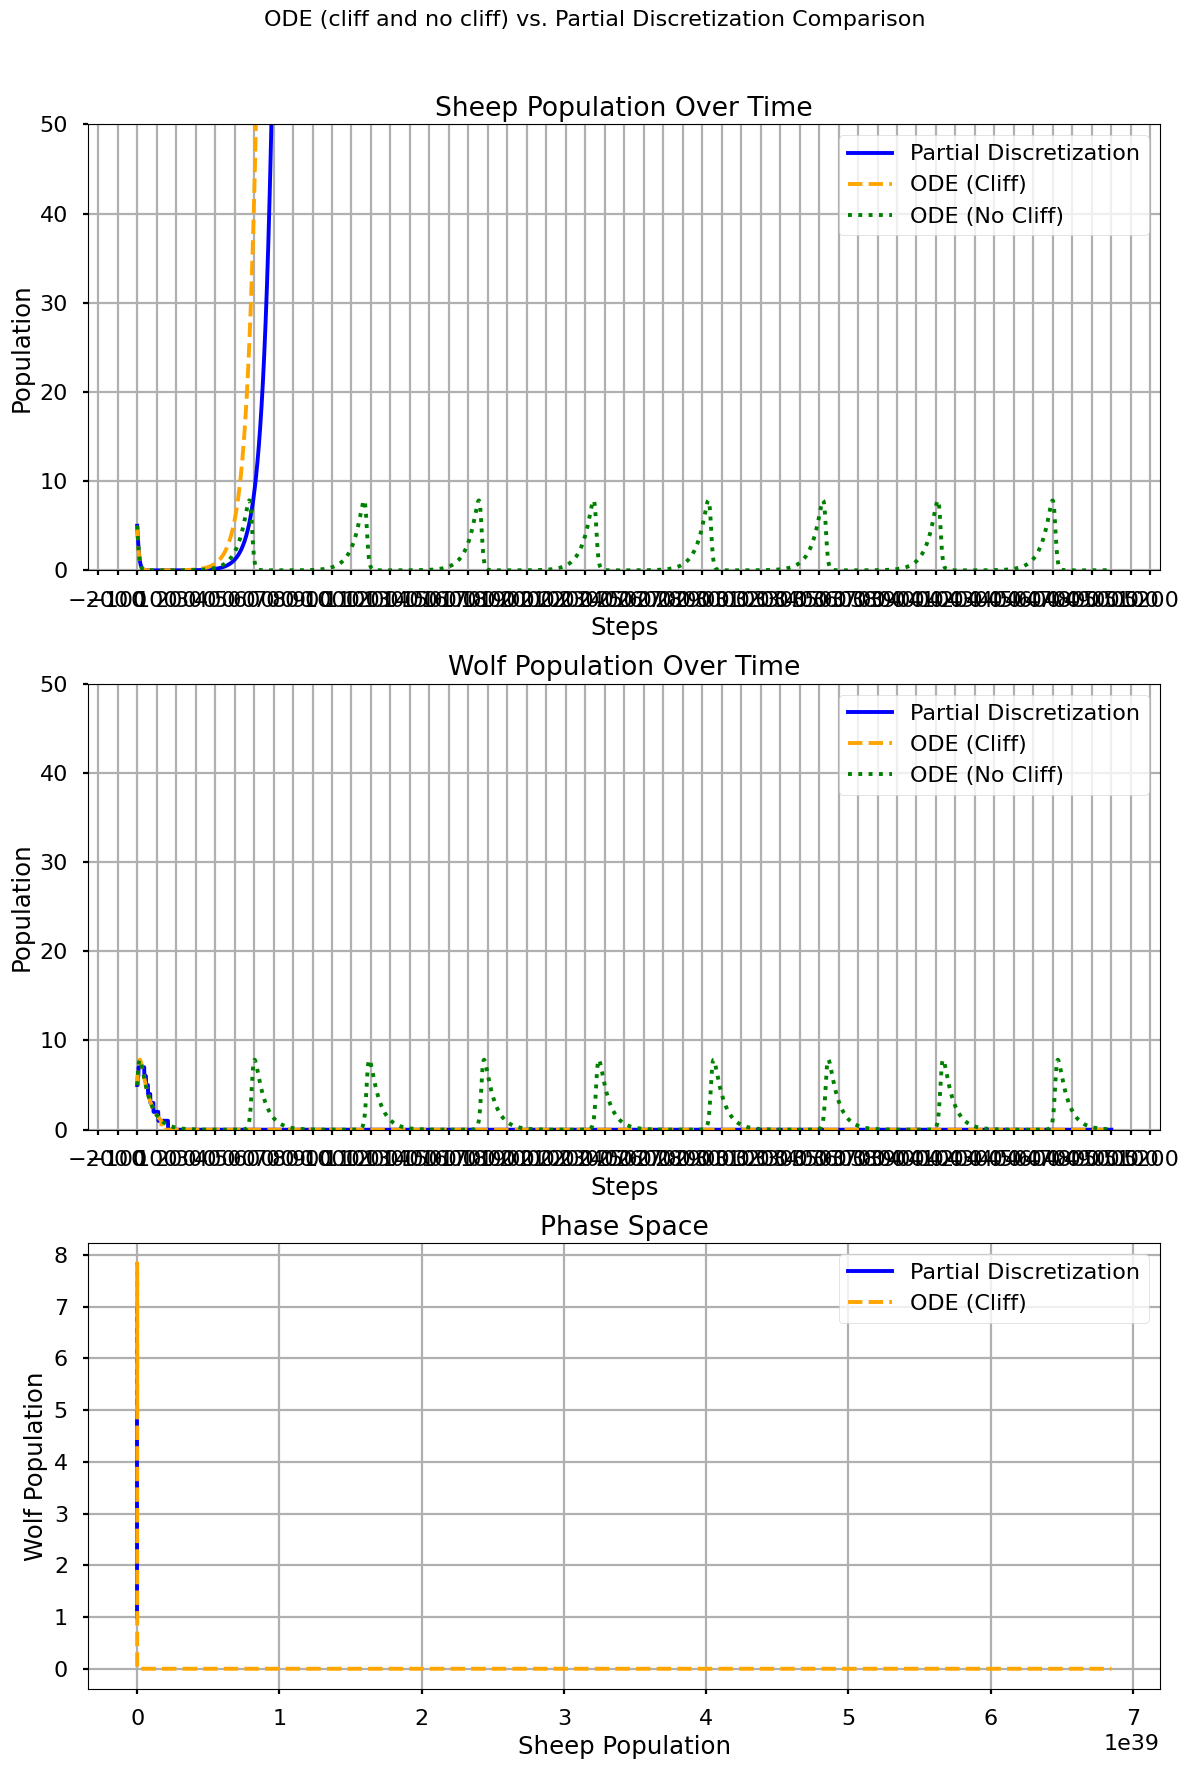

({'s': {'mae': 6.915175291687973e+37,
   'rmse': np.float64(4.890174784464275e+38),
   'r2': -0.020404693258376128},
  'w': {'mae': 0.017698520295940812,
   'rmse': np.float64(0.11705126134494884),
   'r2': 0.9731933884669133}},
            t             s       w
 0       0.00  5.000000e+00  5.0000
 1       0.02  4.597300e+00  5.3947
 2       0.04  4.194400e+00  5.7738
 3       0.06  3.798700e+00  6.1303
 4       0.08  3.416900e+00  6.4583
 ...      ...           ...     ...
 4996   99.92  6.321364e+39  0.0000
 4997   99.94  6.449064e+39  0.0000
 4998   99.96  6.579343e+39  0.0000
 4999   99.98  6.712255e+39  0.0000
 5000  100.00  6.847852e+39  0.0000
 
 [5001 rows x 3 columns],
            t       s       w
 0       0.00  5.0000  5.0000
 1       0.02  4.5973  5.3947
 2       0.04  4.1944  5.7738
 3       0.06  3.7987  6.1303
 4       0.08  3.4169  6.4583
 ...      ...     ...     ...
 4996   99.92  0.0285  0.0428
 4997   99.94  0.0290  0.0420
 4998   99.96  0.0296  0.0412
 4999   99.

In [28]:
model_params = {
        "alpha": 1.0,
        "beta": 1.0,
        "gamma": 1.0,
        "delta": 1.0,
        "s_start": 5,
        "w_start": 5,
        "dt": 0.02,
        "steps": 5000,
        "sheep_max": 210,
        "eps": 0.0
    }

test_prop_partial_discretization_matches_ode(model_params)


Wolves went extinct at step 915
{'steps': 1000, 'sheep_history': [5, 4.91, 4.82162, 4.73483084, 4.64960388488, 4.56591101495216, 4.483724616683022, 4.403017573582727, 4.323763257258238, 4.24593551862759, 4.169508679292293, 4.0944575230650315, 4.020757287649861, 3.9483836564721635, 3.8773127506556646, 3.8075211211438624, 3.738985740963273, 3.671683997625934, 3.6055936856686674, 3.5406929993266316, 3.476960525338752, 3.4143752358826545, 3.3529164816367665, 3.2925639849673045, 3.233297833237893, 3.175098472239611, 3.1179466997392984, 3.061823659143991, 3.0067108332793993, 2.9525900382803703, 2.8994434175913235, 2.8472534360746797, 2.7960028742253353, 2.745674822489279, 2.6962526756844722, 2.6477201275221516, 2.600061165226753, 2.5532600642526715, 2.5073013830961233, 2.462169958200393, 2.417850898952786, 2.3743295827716357, 2.331591650281746, 2.289623000576675, 2.248409786566295, 2.2079384104081017, 2.168195519020756, 2.1291679996783826, 2.0908429756841715, 2.0532078021218565, 2.0162500616

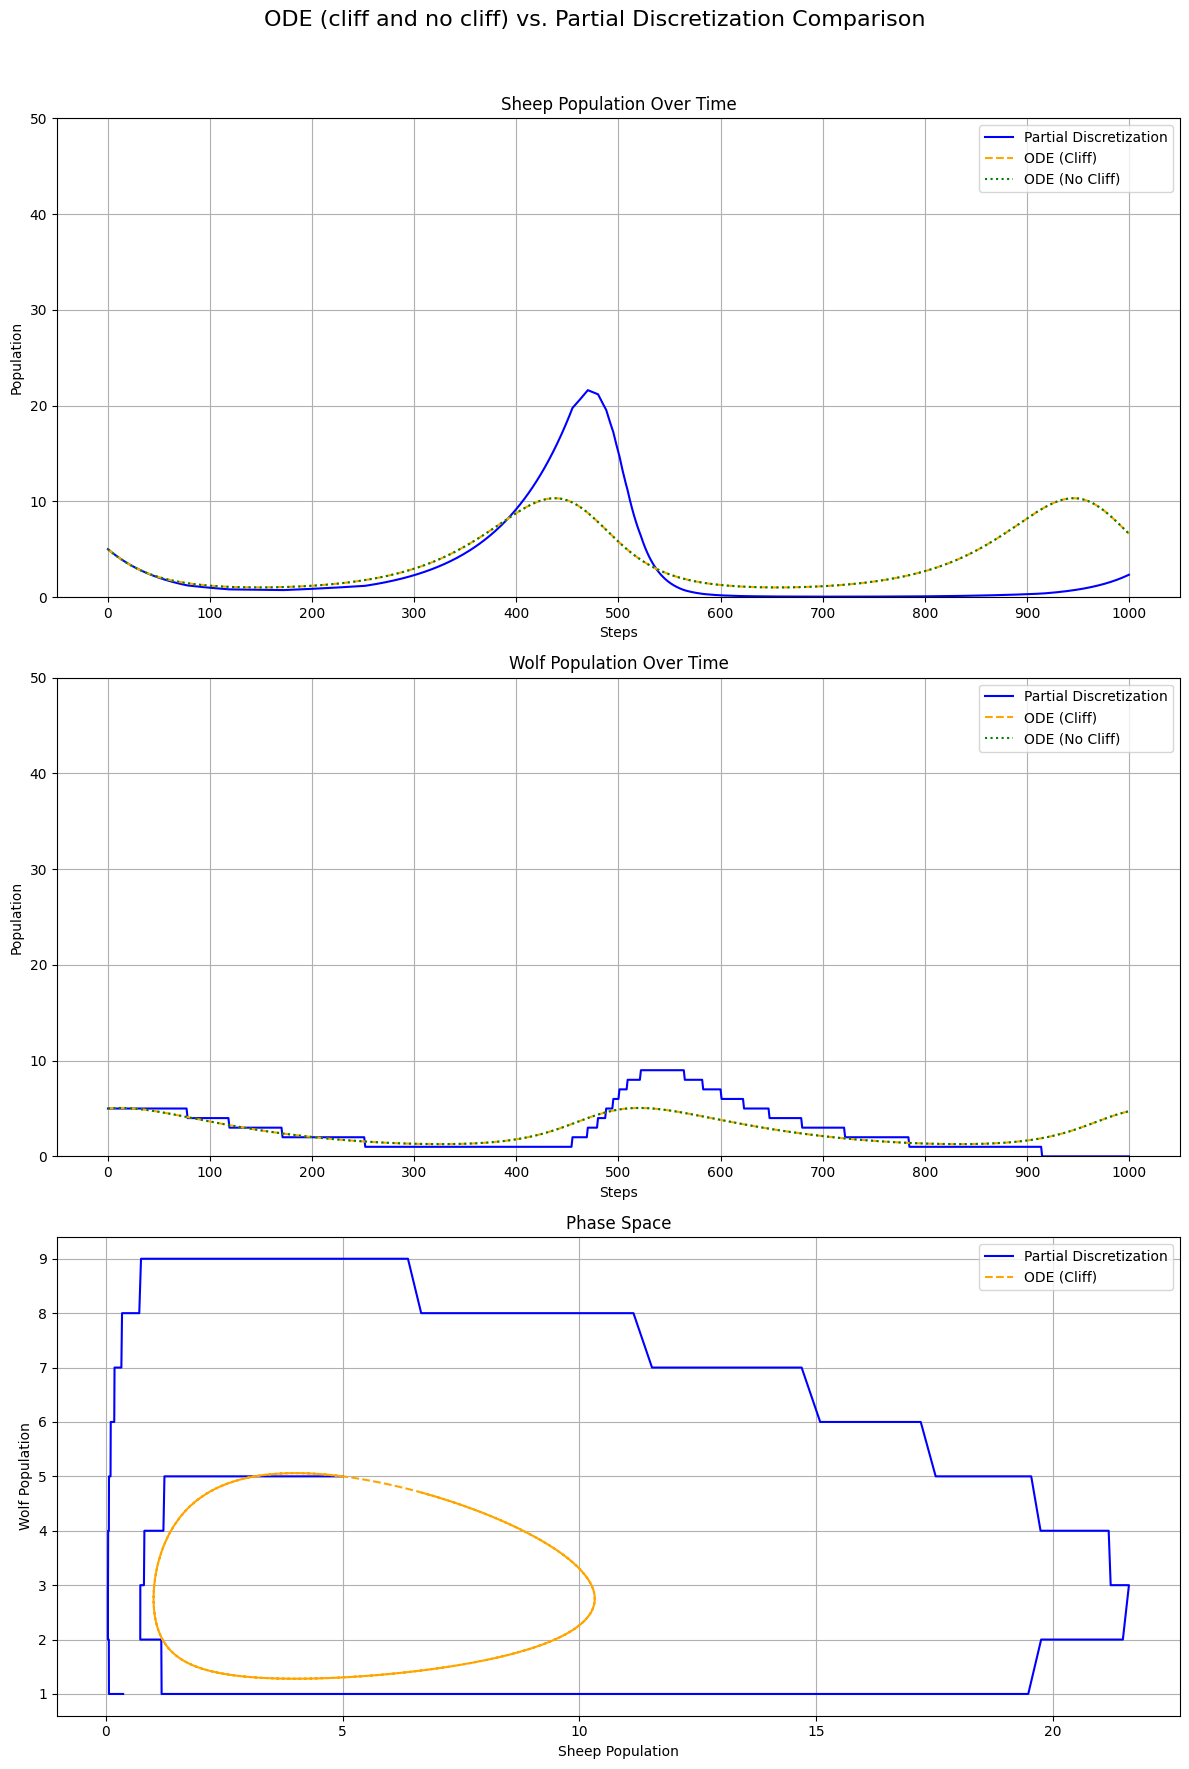

({'s': {'mae': 2.6816276944351416,
   'rmse': np.float64(4.326171599355905),
   'r2': -0.8950304685691022},
  'w': {'mae': 1.1449035964035965,
   'rmse': np.float64(1.6887319474208335),
   'r2': -0.7437350414751753}},
           t       s       w
 0      0.00  5.0000  5.0000
 1      0.02  4.9106  5.0096
 2      0.04  4.8225  5.0182
 3      0.06  4.7356  5.0261
 4      0.08  4.6500  5.0330
 ...     ...     ...     ...
 996   19.92  7.0337  4.6088
 997   19.94  6.9291  4.6364
 998   19.96  6.8246  4.6631
 999   19.98  6.7202  4.6891
 1000  20.00  6.6161  4.7142
 
 [1001 rows x 3 columns],
           t       s       w
 0      0.00  5.0000  5.0000
 1      0.02  4.9106  5.0096
 2      0.04  4.8225  5.0182
 3      0.06  4.7356  5.0261
 4      0.08  4.6500  5.0330
 ...     ...     ...     ...
 996   19.92  7.0337  4.6088
 997   19.94  6.9291  4.6364
 998   19.96  6.8246  4.6631
 999   19.98  6.7202  4.6891
 1000  20.00  6.6161  4.7142
 
 [1001 rows x 3 columns],
           t         s  w
 0  

In [3]:
model_params["alpha"] = 1.1
model_params["beta"] = 0.4
model_params["gamma"] = 0.4
model_params["delta"] = 0.1

test_prop_partial_discretization_matches_ode(model_params)

Wolves went extinct at step 2789
{'steps': 5000, 'sheep_history': [5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.98, 4.9600800000000005, 4.94023968, 4.92047872128, 4.90079680639488, 4.8811936191693, 4.861668844692623, 4.842222169313853, 4.822853280636598, 4.803561867514051, 4.784347620043995, 4.765210229563819, 4.746149388645564, 4.727164791090981, 4.708256131926618, 4.689423107398911, 4.670665414969315, 4.651982753309438, 4.633374822296201, 4.614841323007016, 4.596381957714988, 4.577996429884128, 4.559684444164591, 4.5414457063879325, 4.523279923562381, 4.505186803868131, 4.487166056652659, 4.4692173924260485, 4.451340522856344, 4.433535160764919, 4.415801020121859, 4.3981378160413716, 4.380545264777206, 4.363023083718097, 4.345570991383225, 4.3281887074176915, 4.31087595258802, 

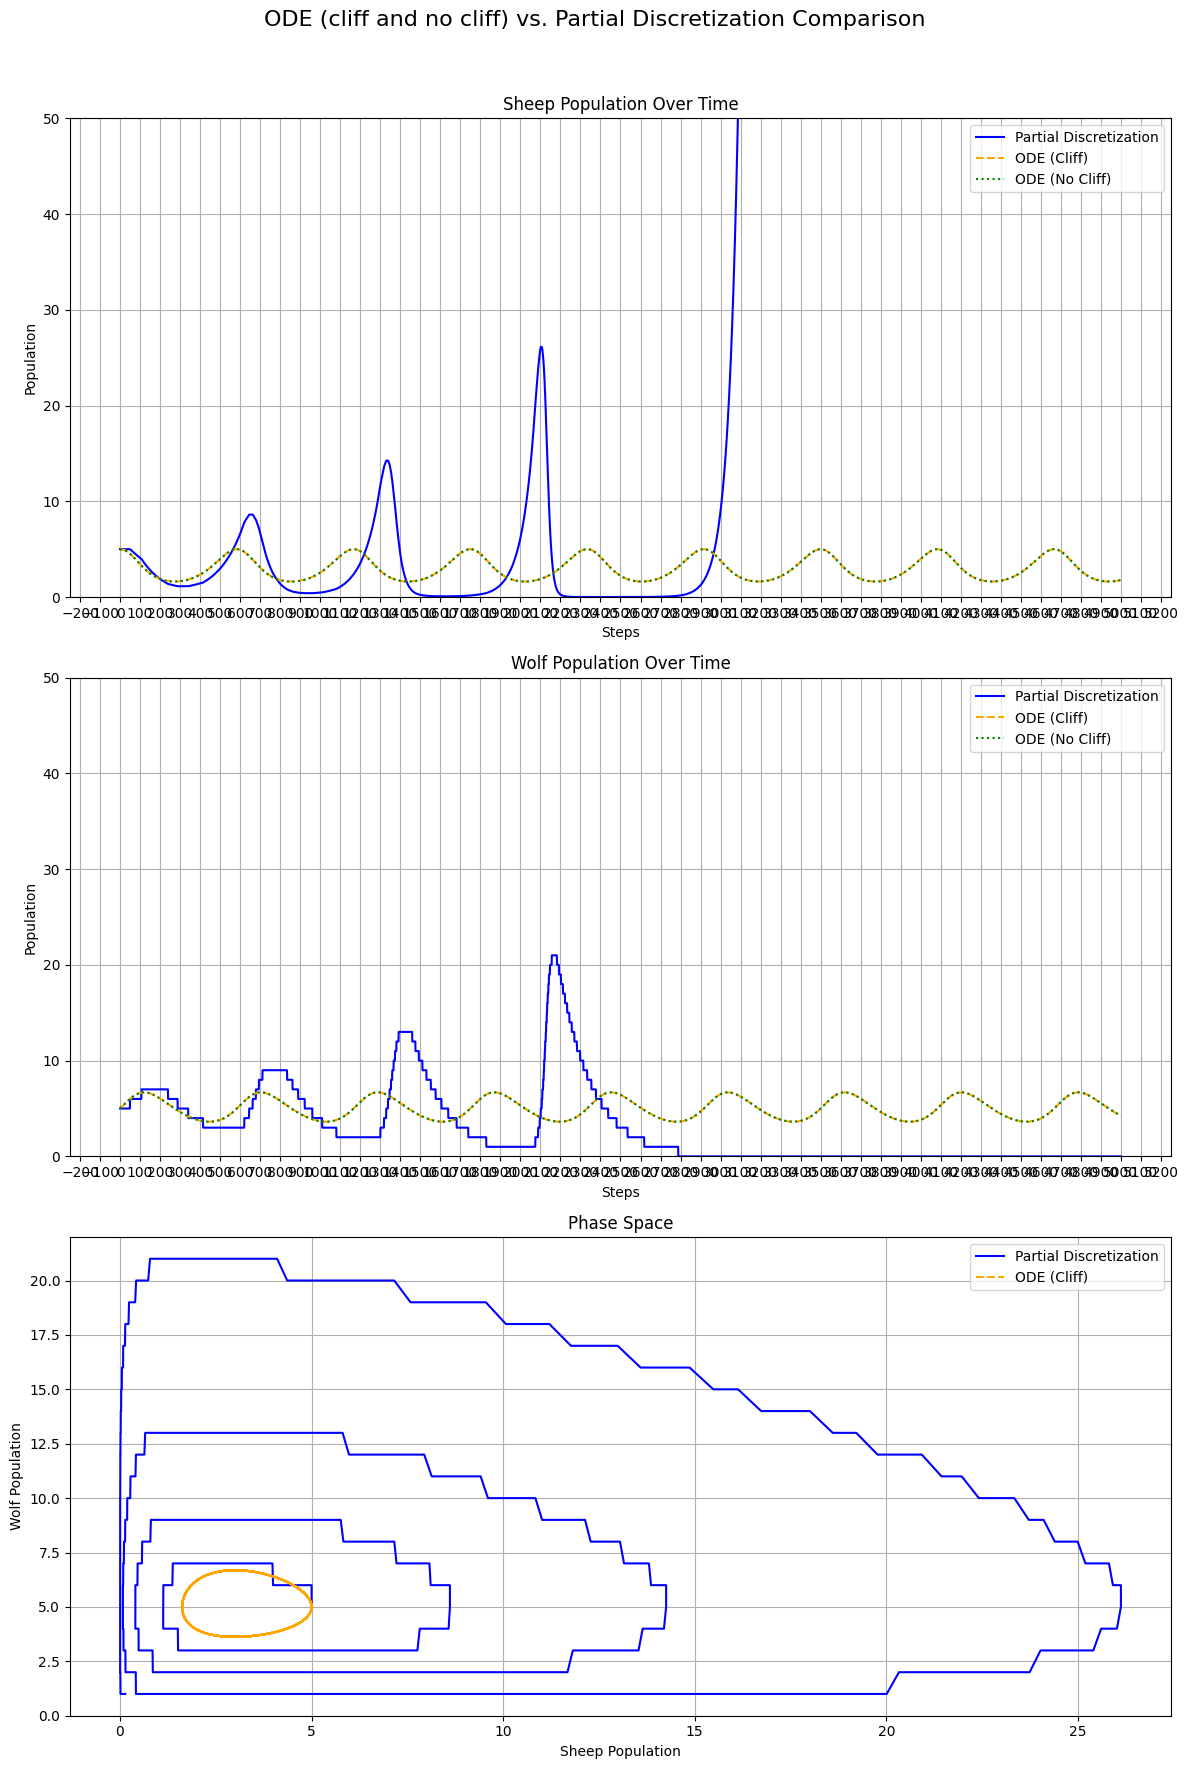

({'s': {'mae': 80.01767474999686,
   'rmse': np.float64(126.55595577744911),
   'r2': -11463.283748072323},
  'w': {'mae': 4.00476798640272,
   'rmse': np.float64(4.79612053845586),
   'r2': -18.92048398782929}},
            t       s       w
 0       0.00  5.0000  5.0000
 1       0.02  4.9998  5.0200
 2       0.04  4.9992  5.0402
 3       0.06  4.9982  5.0603
 4       0.08  4.9968  5.0806
 ...      ...     ...     ...
 4996   99.92  1.7618  4.2980
 4997   99.94  1.7668  4.2874
 4998   99.96  1.7718  4.2769
 4999   99.98  1.7770  4.2664
 5000  100.00  1.7823  4.2560
 
 [5001 rows x 3 columns],
            t       s       w
 0       0.00  5.0000  5.0000
 1       0.02  4.9998  5.0200
 2       0.04  4.9992  5.0402
 3       0.06  4.9982  5.0603
 4       0.08  4.9968  5.0806
 ...      ...     ...     ...
 4996   99.92  1.7618  4.2980
 4997   99.94  1.7668  4.2874
 4998   99.96  1.7718  4.2769
 4999   99.98  1.7770  4.2664
 5000  100.00  1.7823  4.2560
 
 [5001 rows x 3 columns],
           

In [4]:
model_params["alpha"] = 1.0
model_params["beta"] = 0.2
model_params["gamma"] = 0.3
model_params["delta"] = 0.1

model_params["steps"] = 5000

test_prop_partial_discretization_matches_ode(model_params)

### Notes

[^1] The Wikipedia page uses the word, "density," to describe the function of the varibles x and y. We think this is both incorrect and specifically a departure from the works of Lotka and Volterra. We have removed the word from our description.